In [1]:
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
import torchvision
import torch
import os
import random
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pathlib import Path
import gc
import pickle
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from tasksim import *
from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.cluster import GaussianCluster as GMM
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.decomposition import PCA
import seaborn as sns
sns.set()

from joblib import Parallel, delayed
import time


matplotlib.style.use('ggplot')

In [50]:
def stratified_sample(y, p=0.67, replace=False, seed=1234):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    np.random.seed(seed)
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)

def split_data(df, p=0.67):
    '''
    Splits dataframe into two dataframes using p value as a proportion. 
    Make sure that all classes are present.
    
    Parameters:
    df: pandas DataFrame, a dataframe to split that has a 'label' column
    p: float, a proprotion in which the dataframe should be splitted
    
    Returns:
    df_1: pandas DataFrame, a dataframe with the first portion of data that is equivalent to p value
    df_2: pandas DataFrame, rest of the data
    
    '''
    main_label_list = df['label'].tolist()
    ind_list = stratified_sample(main_label_list, p)
    df_1 = df[df.index.isin(ind_list)].sample(frac=1).reset_index(drop=True)
    df_2 = df[~df.index.isin(ind_list)].sample(frac=1).reset_index(drop=True)
    
    return df_1, df_2

class IconDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform, data_root, run, noise_str):
        self.class_names = df['class'].unique().tolist()
        self.image_dir = data_root
        self.transform = transform
        self.total = len(df)
        self.image_names = df['image_path'].to_list()
        self.labels = df['label'].to_numpy() if noise_str=='00' else df['%s_%s' %(noise_str, run)].to_numpy()
        self.targets = self.labels
                    
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = self.transform(Image.open(image_path).convert('RGB'))
        label = self.labels[idx]
        target = self.labels[idx]
        return image, label

    
image_size = (128, 128)
resnet_mean = [0.485, 0.456, 0.406]
resnet_std = [0.229, 0.224, 0.225]

#Creating a Transformation Object
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=image_size),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    #Normalizing the data to the data that the ResNet18 was trained on
    torchvision.transforms.Normalize(mean = resnet_mean ,
                                    std = resnet_std) 
    
])


#Creating a Transformation Object
test_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=image_size),
    # We don't do data augmentation in the test/val set    
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = resnet_mean,
                                    std = resnet_std) 
    
])

#build model using Resnext50 as backbone
class Resnext50(torch.nn.Module):
    def __init__(self, n_classes, name):
        super().__init__()
        self.name = name
        resnet = torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
        resnet.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.soft = torch.nn.Softmax(dim=1)

    def forward(self, x):
        return self.soft(self.base_model(x))

def train_loop(dataloader, model, loss_fn, optimizer, mode="flat", lookup=[], fine_to_coarse={}, 
               batch_size=64):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    counter = 0
    with tqdm(dataloader, unit="batch") as tepoch:
        for X_cpu, y_cpu in tepoch:
            counter += 1
            if mode == "fine":
                y_cpu = torch.tensor([lookup.index(i) for i in y_cpu])
            elif mode == "coarse":
                y_cpu = torch.tensor([fine_to_coarse[int(target)] for target in y_cpu])
            X, y = X_cpu.to(device), y_cpu.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y.type(torch.long))
            loss.backward() 
            optimizer.step() 
            train_loss += loss.item() 
            avg_loss = train_loss / counter
            tepoch.set_postfix(loss=avg_loss)
    return avg_loss
    
    
def eval_model(dataloader, model, loss_fn, mode="flat", lookup=[], fine_to_coarse={}, 
               return_probab=False, batch_size=64):
    model.eval()
    predicts = []
    targets = []
    val_running_loss = 0.0
    
    for counter, (images, labels) in enumerate(dataloader):
        if mode == "fine":
            labels = torch.tensor([lookup.index(i) for i in labels])
        elif mode == "coarse":
            labels = torch.tensor([fine_to_coarse[int(i)] for i in labels])
        else:
            labels = torch.tensor(labels)
        imageGPU = images.to(device)
        
        outputs = torch.Tensor.cpu(model(imageGPU))
        loss = loss_fn(outputs, labels.type(torch.long))
        val_running_loss += loss.item()
        predicts.append(outputs.detach().numpy())
        targets.append(labels)
    val_loss = val_running_loss / counter  
    predicts = np.vstack(predicts)
    targets = np.hstack(targets)
    if return_probab:
        return predicts, targets
    else:
        predicts = np.argmax(predicts, axis=1)
        return val_loss, accuracy_score(targets, predicts)

    

def train_and_validate(epochs, model, loss_fn, optimizer, train_dl, test_dl, val_dl,
                       mode="flat", fine_to_coarse={}, coarse_label=None, lookup=[], 
                       model_path = None):

    early_stopping=EarlyStopping()
    #lr_scheduler = LRScheduler(optimizer)
    
    if model_path is None:
        model_path = '/models/%s.pth' %model.name
    min_loss= 1000
    max_acc = 0
    train_loss= []
    val_loss, val_accuracy = [], []
    for t in range(epochs):
        if mode == "fine":
            print(f"Coarse label {coarse_label} Epoch {t+1}\n-------------------------------")
        else:
            print(f"Epoch {t+1}\n-------------------------------")
        train_epoch_loss = train_loop(train_dl, model, loss_fn, optimizer, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
        val_epoch_loss, val_epoch_acc = eval_model(val_dl, model,loss_fn, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
        
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_acc)
        if val_epoch_loss < min_loss:
            max_acc = val_epoch_acc
            min_loss = val_epoch_loss
            torch.save(model.state_dict(), model_path)
        elif val_epoch_acc>max_acc:
            max_acc = val_epoch_acc
            torch.save(model.state_dict(), model_path)
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            break
        print("train loss %s, validation loss %s, validation accuracy %s" %(train_epoch_loss, 
                                                                            val_epoch_loss, 
                                                                            val_epoch_acc))
    test_loss, test_acc = eval_model(test_dl, model, loss_fn, mode=mode, fine_to_coarse=fine_to_coarse, lookup=lookup)
    print("Done! Saved model with test accuracy %s and loss %s" %(test_acc, test_loss))
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(val_accuracy, color='blue', label='validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"models/validationAccuracy{model.name}.png")
    plt.show()
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"models/losses{model.name}.png")
    plt.show()
    
    return  test_acc


In [3]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [45]:
seeds = [1234,6265, 2403, 941,2225]

#learning rate is the same for all models
learning_rate = 1e-4 

label_noises = [0.1, 0.2, 0.3, 0.5, 0.8]#[0.0, 0.1, 0.2, 0.3, 0.5, 0.8]
fine_tuned_model_path = '../../../teamdrive/transmediasp/kate/models/icons_fine_tuned_model.pth'

In [13]:
#load dataframe with labels
df = pd.read_csv('../../../teamdrive/transmediasp/kate/hierarchy/label_noise_data_frame_with_splits.csv', index_col=0)
del df['Unnamed: 0.1']

n_classes = len(df['class'].unique())
df.head(5)

,image_path,class,label,split,10_0,10_1,10_2,10_3,10_4,20_0,...,split_80_0,split_80_1,split_80_2,split_80_3,split_80_4,split_90_0,split_90_1,split_90_2,split_90_3,split_90_4
0,../../../data/testdotai/close/_e4530e1aae88750...,close,0,main,0,0,0,36,0,90,...,main,main,test,main,test,main,main,main,test,main
1,../../../data/testdotai/close/~02a0c54fd8374b4...,close,0,main,0,0,0,0,0,48,...,main,test,main,main,main,main,main,main,main,test
2,../../../data/testdotai/close/_10099f88fd8333f...,close,0,main,0,0,0,0,0,0,...,main,main,main,main,main,test,main,main,test,main
3,../../../data/testdotai/close/_bcd740021f1a62a...,close,0,main,0,0,0,0,0,0,...,test,main,main,main,main,main,test,test,test,main
4,../../../data/testdotai/close/_047b3f69c7c53b8...,close,0,main,0,0,0,0,0,0,...,main,test,main,main,main,test,main,main,test,main


In [15]:
torch.cuda.is_available()

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
    
device = torch.device(dev)  

In [53]:
#create a dictionary to save results in
flat_accuracies = defaultdict()

Epoch 1
-------------------------------


100%|██████████| 1462/1462 [11:46<00:00,  2.07batch/s, loss=4.12]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.11916524946445, validation loss 4.047523968928569, validation accuracy 0.5514964170296474
Epoch 2
-------------------------------


100%|██████████| 1462/1462 [09:38<00:00,  2.53batch/s, loss=3.99]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9914527567238554, validation loss 4.031932240133887, validation accuracy 0.5649852465926655
Epoch 3
-------------------------------


100%|██████████| 1462/1462 [19:30<00:00,  1.25batch/s, loss=3.96]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.963643507005089, validation loss 4.001726835697621, validation accuracy 0.595897147674582
Epoch 4
-------------------------------


100%|██████████| 1462/1462 [09:36<00:00,  2.54batch/s, loss=3.94]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.938100913154769, validation loss 3.9817572305868336, validation accuracy 0.6158493747365463
Epoch 5
-------------------------------


100%|██████████| 1462/1462 [09:38<00:00,  2.53batch/s, loss=3.91]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9123609602532863, validation loss 3.9692363502743007, validation accuracy 0.6270900660390614
Epoch 6
-------------------------------


100%|██████████| 1462/1462 [11:40<00:00,  2.09batch/s, loss=3.9]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.8977632533998396, validation loss 3.964154761116784, validation accuracy 0.6338344808205705
Epoch 7
-------------------------------


100%|██████████| 1462/1462 [11:18<00:00,  2.15batch/s, loss=3.89]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.890989291358092, validation loss 3.9500879274832235, validation accuracy 0.6480258535899958
Epoch 8
-------------------------------


100%|██████████| 1462/1462 [15:29<00:00,  1.57batch/s, loss=3.88]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.876217474689562, validation loss 3.9320263067881265, validation accuracy 0.664746381902487
Epoch 9
-------------------------------


100%|██████████| 1462/1462 [09:36<00:00,  2.54batch/s, loss=3.86]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.8627686582087817, validation loss 3.9230087469289967, validation accuracy 0.6744414781509063
Epoch 10
-------------------------------


100%|██████████| 1462/1462 [09:37<00:00,  2.53batch/s, loss=3.86]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.857411835653511, validation loss 3.9218906088992282, validation accuracy 0.6747224954334692
Epoch 11
-------------------------------


100%|██████████| 1462/1462 [11:38<00:00,  2.09batch/s, loss=3.85]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.8544533220100665, validation loss 3.919584983103984, validation accuracy 0.6768301250526907
Epoch 12
-------------------------------


100%|██████████| 1462/1462 [14:20<00:00,  1.70batch/s, loss=3.85]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.8478528425892464, validation loss 3.9141920665362933, validation accuracy 0.6823099620626668
Epoch 13
-------------------------------


100%|██████████| 1462/1462 [12:19<00:00,  1.98batch/s, loss=3.84]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.843796394918262, validation loss 3.911896050513328, validation accuracy 0.685260643529577
Epoch 14
-------------------------------


100%|██████████| 1462/1462 [10:33<00:00,  2.31batch/s, loss=3.84]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 1 of 5
train loss 3.8422861164473967, validation loss 3.914726581659403, validation accuracy 0.6827314879865112
Epoch 15
-------------------------------


100%|██████████| 1462/1462 [10:14<00:00,  2.38batch/s, loss=3.84]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 2 of 5
train loss 3.840307874164242, validation loss 3.918203880121042, validation accuracy 0.6778136855416608
Epoch 16
-------------------------------


100%|██████████| 1462/1462 [09:38<00:00,  2.53batch/s, loss=3.84]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.838545094110408, validation loss 3.9047274245872154, validation accuracy 0.6914430237459603
Epoch 17
-------------------------------


100%|██████████| 1462/1462 [17:31<00:00,  1.39batch/s, loss=3.84]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 3 of 5
train loss 3.837144605438295, validation loss 3.9109617740184337, validation accuracy 0.68554166081214
Epoch 18
-------------------------------


100%|██████████| 1462/1462 [09:41<00:00,  2.52batch/s, loss=3.84]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.8351844951979275, validation loss 3.901452096732887, validation accuracy 0.6946747224954335
Epoch 19
-------------------------------


100%|██████████| 1462/1462 [09:36<00:00,  2.53batch/s, loss=3.83]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 4 of 5
train loss 3.834308437870563, validation loss 3.9037147040839666, validation accuracy 0.693269636082619
Epoch 20
-------------------------------


100%|██████████| 1462/1462 [11:40<00:00,  2.09batch/s, loss=3.83]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.8295183220901174, validation loss 3.9006475349804304, validation accuracy 0.695798791625685
Epoch 21
-------------------------------


100%|██████████| 1462/1462 [09:37<00:00,  2.53batch/s, loss=3.83]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 5 of 5
INFO: Early stopping


/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Done! Saved model with test accuracy 0.7036775314312634 and loss 3.8662199141844265


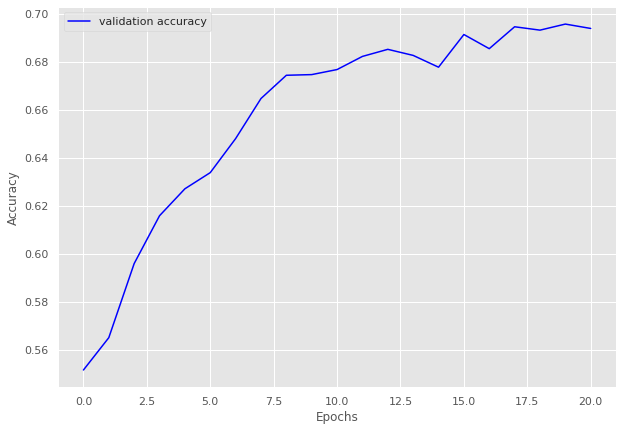

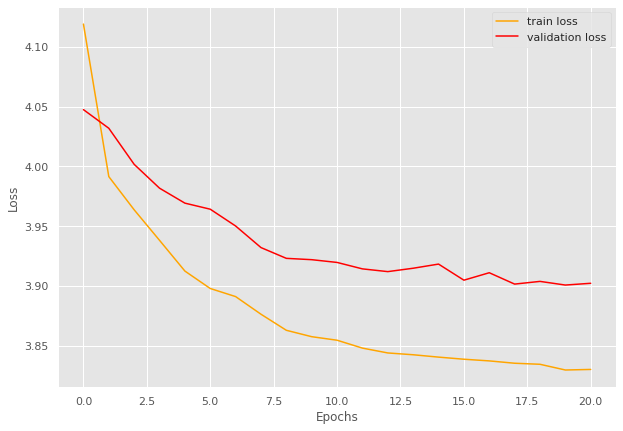

defaultdict(None, {'0': defaultdict(None, {'10': 0.7036775314312634})})
Epoch 1
-------------------------------


100%|██████████| 1463/1463 [18:36<00:00,  1.31batch/s, loss=4.16]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.159588526310533, validation loss 4.122300815582276, validation accuracy 0.47688598979013047
Epoch 2
-------------------------------


100%|██████████| 1463/1463 [09:41<00:00,  2.51batch/s, loss=4.05]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.047333985261533, validation loss 4.0794949314811015, validation accuracy 0.5197107203630176
Epoch 3
-------------------------------


100%|██████████| 1463/1463 [09:37<00:00,  2.53batch/s, loss=4.02]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.021091578842758, validation loss 4.057974711331454, validation accuracy 0.5409812819058423
Epoch 4
-------------------------------


100%|██████████| 1463/1463 [11:49<00:00,  2.06batch/s, loss=4]   
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.004523743364148, validation loss 4.04638275233182, validation accuracy 0.5499149177538287
Epoch 5
-------------------------------


100%|██████████| 1463/1463 [09:49<00:00,  2.48batch/s, loss=3.99]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9865864222781426, validation loss 4.033044919100675, validation accuracy 0.5645207033465683
Epoch 6
-------------------------------


100%|██████████| 1463/1463 [20:12<00:00,  1.21batch/s, loss=3.98]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9801231017278957, validation loss 4.028598338907416, validation accuracy 0.5674985819625639
Epoch 7
-------------------------------


100%|██████████| 1463/1463 [09:37<00:00,  2.53batch/s, loss=3.97]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9673323447135567, validation loss 4.017304762926969, validation accuracy 0.5788428814520703
Epoch 8
-------------------------------


100%|██████████| 1463/1463 [11:42<00:00,  2.08batch/s, loss=3.96]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.963257685476839, validation loss 4.007544123042713, validation accuracy 0.5897617697107204
Epoch 9
-------------------------------


100%|██████████| 1463/1463 [09:38<00:00,  2.53batch/s, loss=3.95]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.954246480906572, validation loss 3.995194656198675, validation accuracy 0.6030913216108905
Epoch 10
-------------------------------


100%|██████████| 1463/1463 [10:09<00:00,  2.40batch/s, loss=3.94]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 1 of 5
train loss 3.944751018868353, validation loss 3.99899893023751, validation accuracy 0.5979863868406126
Epoch 11
-------------------------------


100%|██████████| 1463/1463 [16:40<00:00,  1.46batch/s, loss=3.94]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9376122861876524, validation loss 3.9934755498712713, validation accuracy 0.6036585365853658
Epoch 12
-------------------------------


100%|██████████| 1463/1463 [09:37<00:00,  2.53batch/s, loss=3.93]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.932125138486809, validation loss 3.986582740870389, validation accuracy 0.6106069200226886
Epoch 13
-------------------------------


100%|██████████| 1463/1463 [09:37<00:00,  2.54batch/s, loss=3.93]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9257483679549137, validation loss 3.9775509227405896, validation accuracy 0.6198241633579127
Epoch 14
-------------------------------


100%|██████████| 1463/1463 [11:47<00:00,  2.07batch/s, loss=3.92]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9199872453654376, validation loss 3.9734430811621926, validation accuracy 0.624503686897334
Epoch 15
-------------------------------


100%|██████████| 1463/1463 [12:56<00:00,  1.88batch/s, loss=3.91]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9137966549730594, validation loss 3.968402437730269, validation accuracy 0.6297504254112308
Epoch 16
-------------------------------


100%|██████████| 1463/1463 [15:34<00:00,  1.57batch/s, loss=3.91]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.908716984179765, validation loss 3.9602204084396364, validation accuracy 0.6372660238230289
Epoch 17
-------------------------------


100%|██████████| 1463/1463 [09:36<00:00,  2.54batch/s, loss=3.9]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 2 of 5
train loss 3.904428444084694, validation loss 3.9610106706619264, validation accuracy 0.6366988088485536
Epoch 18
-------------------------------


100%|██████████| 1463/1463 [09:36<00:00,  2.54batch/s, loss=3.9]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 3 of 5
train loss 3.9034604380901596, validation loss 3.960774237459356, validation accuracy 0.6358479863868406
Epoch 19
-------------------------------


100%|██████████| 1463/1463 [11:38<00:00,  2.10batch/s, loss=3.9]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9016662321918565, validation loss 3.9580562136389994, validation accuracy 0.6384004537719796
Epoch 20
-------------------------------


100%|██████████| 1463/1463 [18:33<00:00,  1.31batch/s, loss=3.9]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9001825227365865, validation loss 3.956190178611062, validation accuracy 0.6403857061826432
Epoch 21
-------------------------------


100%|██████████| 1463/1463 [10:24<00:00,  2.34batch/s, loss=3.9]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 4 of 5
train loss 3.897592201513211, validation loss 3.9583885431289674, validation accuracy 0.63712422007941
Epoch 22
-------------------------------


100%|██████████| 1463/1463 [09:35<00:00,  2.54batch/s, loss=3.9]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 5 of 5
INFO: Early stopping


/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Done! Saved model with test accuracy 0.6412861054677149 and loss 3.928752142978164


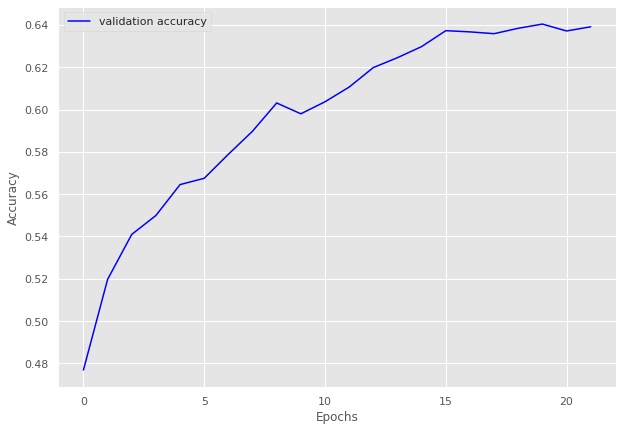

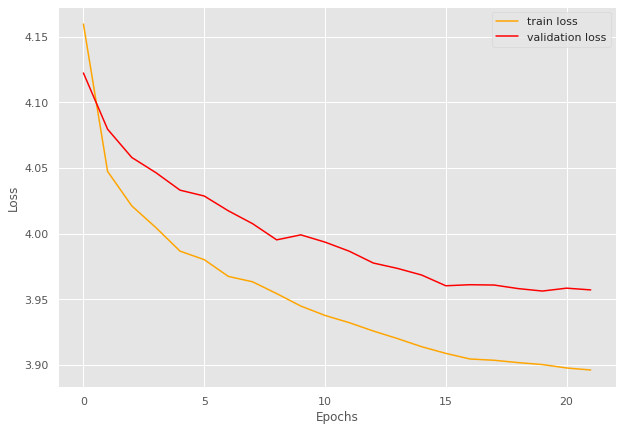

defaultdict(None, {'0': defaultdict(None, {'10': 0.7036775314312634, '20': 0.6412861054677149})})
Epoch 1
-------------------------------


100%|██████████| 1461/1461 [11:36<00:00,  2.10batch/s, loss=4.21]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.2114403810834, validation loss 4.178880923503154, validation accuracy 0.4223680536163083
Epoch 2
-------------------------------


100%|██████████| 1461/1461 [09:33<00:00,  2.55batch/s, loss=4.1]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.097501983224816, validation loss 4.1422977791176185, validation accuracy 0.45741413013124826
Epoch 3
-------------------------------


100%|██████████| 1461/1461 [19:30<00:00,  1.25batch/s, loss=4.07]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.0660623583705515, validation loss 4.112097357844447, validation accuracy 0.48687517453225354
Epoch 4
-------------------------------


100%|██████████| 1461/1461 [09:35<00:00,  2.54batch/s, loss=4.05]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.047758775243687, validation loss 4.102591557545705, validation accuracy 0.49692823233733596
Epoch 5
-------------------------------


100%|██████████| 1461/1461 [09:36<00:00,  2.54batch/s, loss=4.03]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.034912866733402, validation loss 4.089691252321811, validation accuracy 0.5097738061993856
Epoch 6
-------------------------------


100%|██████████| 1461/1461 [11:32<00:00,  2.11batch/s, loss=4.03]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.027414664269147, validation loss 4.086964514878419, validation accuracy 0.5113096900307177
Epoch 7
-------------------------------


100%|██████████| 1461/1461 [09:47<00:00,  2.49batch/s, loss=4.02]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.022749576725265, validation loss 4.086789558599661, validation accuracy 0.5121474448478078
Epoch 8
-------------------------------


100%|██████████| 1461/1461 [16:37<00:00,  1.47batch/s, loss=4.01]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.012919263428486, validation loss 4.07126513257757, validation accuracy 0.5276459089639766
Epoch 9
-------------------------------


100%|██████████| 1461/1461 [09:35<00:00,  2.54batch/s, loss=4.01]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 1 of 5
train loss 4.006112244584477, validation loss 4.071588391656274, validation accuracy 0.5268081541468863
Epoch 10
-------------------------------


100%|██████████| 1461/1461 [09:35<00:00,  2.54batch/s, loss=4]  
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9999086750769437, validation loss 4.061720055502814, validation accuracy 0.5371404635576654
Epoch 11
-------------------------------


100%|██████████| 1461/1461 [11:35<00:00,  2.10batch/s, loss=4]  
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.997571427392927, validation loss 4.0614779210305425, validation accuracy 0.5372800893605139
Epoch 12
-------------------------------


100%|██████████| 1461/1461 [11:17<00:00,  2.16batch/s, loss=3.99]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9930475025777534, validation loss 4.056636352796812, validation accuracy 0.541189611840268
Epoch 13
-------------------------------


100%|██████████| 1461/1461 [16:49<00:00,  1.45batch/s, loss=3.99]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 2 of 5
train loss 3.988262579589572, validation loss 4.057820150444099, validation accuracy 0.5403518570231779
Epoch 14
-------------------------------


100%|██████████| 1461/1461 [09:33<00:00,  2.55batch/s, loss=3.99]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9853343730263315, validation loss 4.04680660823444, validation accuracy 0.5523596760681374
Epoch 15
-------------------------------


100%|██████████| 1461/1461 [11:38<00:00,  2.09batch/s, loss=3.98]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 3 of 5
train loss 3.980555595884904, validation loss 4.048006289714092, validation accuracy 0.5505445406311086
Epoch 16
-------------------------------


100%|██████████| 1461/1461 [09:34<00:00,  2.54batch/s, loss=3.98]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.977091091777428, validation loss 4.042823016106546, validation accuracy 0.5548729405194079
Epoch 17
-------------------------------


100%|██████████| 1461/1461 [16:33<00:00,  1.47batch/s, loss=3.98]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 4 of 5
train loss 3.976732467152663, validation loss 4.048296187375043, validation accuracy 0.5498464116168668
Epoch 18
-------------------------------


100%|██████████| 1461/1461 [09:58<00:00,  2.44batch/s, loss=3.97]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.971370152624236, validation loss 4.038085043967307, validation accuracy 0.5598994694219491
Epoch 19
-------------------------------


100%|██████████| 1461/1461 [09:34<00:00,  2.54batch/s, loss=3.97]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.9693388245352157, validation loss 4.035476291501844, validation accuracy 0.5628316112817648
Epoch 20
-------------------------------


100%|██████████| 1461/1461 [11:36<00:00,  2.10batch/s, loss=3.97]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.966742914886527, validation loss 4.033036640098503, validation accuracy 0.5653448757330355
Epoch 21
-------------------------------


100%|██████████| 1461/1461 [09:37<00:00,  2.53batch/s, loss=3.97]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 3.965149909971839, validation loss 4.031298993944048, validation accuracy 0.567439262775761
Epoch 22
-------------------------------


100%|██████████| 1461/1461 [18:09<00:00,  1.34batch/s, loss=3.96]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 5 of 5
INFO: Early stopping


/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Done! Saved model with test accuracy 0.5745958837558519 and loss 3.995113364255653


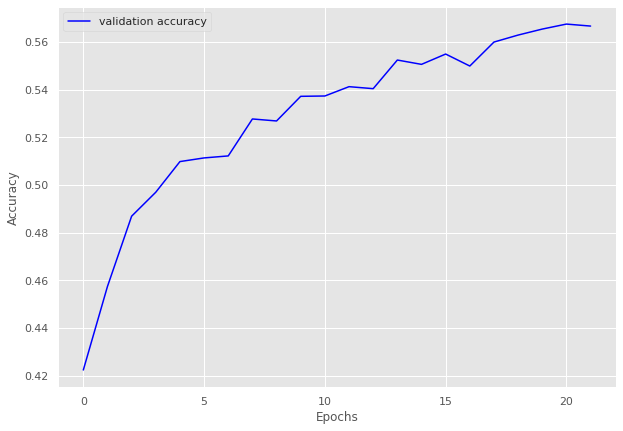

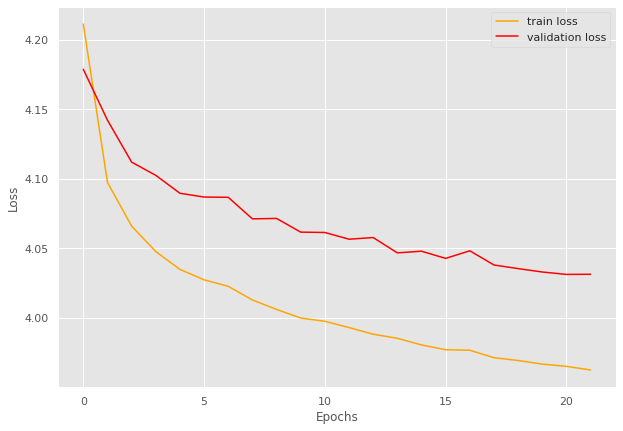

defaultdict(None, {'0': defaultdict(None, {'10': 0.7036775314312634, '20': 0.6412861054677149, '30': 0.5745958837558519})})
Epoch 1
-------------------------------


100%|██████████| 1461/1461 [09:38<00:00,  2.53batch/s, loss=4.32]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.320605316854029, validation loss 4.313607241656329, validation accuracy 0.2871536523929471
Epoch 2
-------------------------------


100%|██████████| 1461/1461 [10:15<00:00,  2.38batch/s, loss=4.24]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.237576983710987, validation loss 4.265473327121219, validation accuracy 0.33613210187517495
Epoch 3
-------------------------------


100%|██████████| 1461/1461 [10:27<00:00,  2.33batch/s, loss=4.22]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.215077224290183, validation loss 4.258288121438241, validation accuracy 0.3418695773859502
Epoch 4
-------------------------------


100%|██████████| 1461/1461 [09:32<00:00,  2.55batch/s, loss=4.2]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.200366818684572, validation loss 4.245643650089298, validation accuracy 0.3533445284075007
Epoch 5
-------------------------------


100%|██████████| 1461/1461 [18:29<00:00,  1.32batch/s, loss=4.18]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.1813360693355195, validation loss 4.2159247398376465, validation accuracy 0.38399104394066613
Epoch 6
-------------------------------


100%|██████████| 1461/1461 [09:40<00:00,  2.52batch/s, loss=4.17]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.167042054353227, validation loss 4.20900112444216, validation accuracy 0.39112790372236217
Epoch 7
-------------------------------


100%|██████████| 1461/1461 [09:37<00:00,  2.53batch/s, loss=4.16]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.159541578345067, validation loss 4.205724419774236, validation accuracy 0.39392667226420375
Epoch 8
-------------------------------


100%|██████████| 1461/1461 [11:37<00:00,  2.09batch/s, loss=4.15]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.153037625579782, validation loss 4.200631158845919, validation accuracy 0.3986845787853345
Epoch 9
-------------------------------


100%|██████████| 1461/1461 [09:36<00:00,  2.53batch/s, loss=4.15]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.146114181933706, validation loss 4.193136318309887, validation accuracy 0.4059613769941226
Epoch 10
-------------------------------


100%|██████████| 1461/1461 [21:13<00:00,  1.15batch/s, loss=4.14]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 1 of 5
train loss 4.139211226292949, validation loss 4.194726617486627, validation accuracy 0.4038623005877414
Epoch 11
-------------------------------


100%|██████████| 1461/1461 [09:41<00:00,  2.51batch/s, loss=4.14]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.136219239251243, validation loss 4.189517828795287, validation accuracy 0.41029946823397706
Epoch 12
-------------------------------


100%|██████████| 1461/1461 [11:10<00:00,  2.18batch/s, loss=4.13]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.12925834479518, validation loss 4.1804079837627235, validation accuracy 0.4186957738595018
Epoch 13
-------------------------------


100%|██████████| 1461/1461 [09:39<00:00,  2.52batch/s, loss=4.13]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 2 of 5
train loss 4.125260870233127, validation loss 4.182386501415356, validation accuracy 0.417156451161489
Epoch 14
-------------------------------


100%|██████████| 1461/1461 [17:00<00:00,  1.43batch/s, loss=4.12]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.122210223571965, validation loss 4.179735836682019, validation accuracy 0.41967534284914637
Epoch 15
-------------------------------


100%|██████████| 1461/1461 [10:08<00:00,  2.40batch/s, loss=4.12]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.117855445723433, validation loss 4.176946622831327, validation accuracy 0.42233417296389586
Epoch 16
-------------------------------


100%|██████████| 1461/1461 [09:37<00:00,  2.53batch/s, loss=4.12]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 3 of 5
train loss 4.1161680241140255, validation loss 4.178606681995563, validation accuracy 0.42121466554715925
Epoch 17
-------------------------------


100%|██████████| 1461/1461 [09:37<00:00,  2.53batch/s, loss=4.12]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.115059813598017, validation loss 4.173661322207065, validation accuracy 0.4256926952141058
Epoch 18
-------------------------------


100%|██████████| 1461/1461 [11:57<00:00,  2.04batch/s, loss=4.11]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 4 of 5
train loss 4.113674529197688, validation loss 4.179455220162332, validation accuracy 0.41967534284914637
Epoch 19
-------------------------------


100%|██████████| 1461/1461 [18:32<00:00,  1.31batch/s, loss=4.11]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.112237885257792, validation loss 4.172429432740083, validation accuracy 0.4270920794850266
Epoch 20
-------------------------------


100%|██████████| 1461/1461 [09:40<00:00,  2.52batch/s, loss=4.11]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss 4.110514064752264, validation loss 4.1696731764991, validation accuracy 0.4297509095997761
Epoch 21
-------------------------------


100%|██████████| 1461/1461 [09:35<00:00,  2.54batch/s, loss=4.11]
/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping counter 5 of 5
INFO: Early stopping


/home/kalytv/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
for run, seed in enumerate(seeds):
    #set manual seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    flat_accuracies['%s' %run] = defaultdict()
    
    for label_noise in label_noises:
        label_noise_str = '00' if label_noise==0.0 else str(int(label_noise*100))

        #prepare data
        main_df = df[df['split_%s_%s' %(label_noise_str, run)] == "main"]
        test_df = df[df['split_%s_%s' %(label_noise_str, run)] == "test"]
        valid_df, train_df  = split_data(main_df, p=0.10)

        # prepare dataloaders
        batch_size = 64

        test_dataset = IconDataset(test_df, test_transform, "", run, label_noise_str)
        train_dataset = IconDataset(train_df, train_transform, "", run, label_noise_str)
        validation_dataset = IconDataset(valid_df, test_transform, "", run, label_noise_str)

        dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        dl_valid = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

        # train flat model 
        gc.collect() 
        torch.cuda.empty_cache()
        epochs= 40

        model = Resnext50(n_classes, name="flat_model_Resnext50_icons_%s_%s" %(run, label_noise_str))
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        model.state_dict(torch.load(fine_tuned_model_path))
        model.to(device)
        loss_fn = torch.nn.CrossEntropyLoss().to(device)

        test_accuracy =train_and_validate(epochs, model, loss_fn, optimizer, 
                                                            dl_train, dl_test, dl_valid,
                                                            model_path = '../../../teamdrive/transmediasp/kate/models/base/%s.pth' %model.name )
        flat_accuracies['%s' %run]['%s' %label_noise_str] = test_accuracy
        print(flat_accuracies)
        with open('../../../teamdrive/transmediasp/kate/flat_accuracies.p', 'wb') as handle:
            pickle.dump(flat_accuracies, handle)

